# Golf

Calculate the trajectory of a golf ball of mass 46 grams and calculate the trajectories as a function of angle (use $\theta = 45^\circ, 30^\circ, 15^\circ$ and $9^\circ$). The initial velocity of the golf ball to be 70 m/s. For the drag, assume a general form of 

$$
F_{drag} = -C\rho Av^2
$$
where $\rho$ is the density of air (at sea level), $1.29 kg/m^3$, $A$ is the frontal area of the golf ball, $0.0014 m^2$, and $C$ is a coefficient. 

The differential equation for the flying golf ball is
$$
\ddot{\textbf{x}} = \frac{\textbf{F}_{total}}{m}
$$
This second-order equation could be broken into two first-order equations:
$$
\dot{\textbf{x}}=\textbf{v} \\
\dot{\textbf{v}}=\frac{\textbf{F}_{total}}{m}
$$
Decompose both velocity and displacement into the x and y directions, then the individual Euler-method solution to those first-order equations are
$$
x(t+\Delta t) = x(t)+v_x(t)\Delta t \\
v_x(t+\Delta t) = v_x(t)+\frac{F_x}{m}\Delta t
$$
and
$$
y(t+\Delta t) = y(t)+v_y(t)\Delta t \\
v_y(t+\Delta t) = v_y(t)+\frac{F_y}{m}\Delta t
$$
Substituion of the initial velocity in x and y dirctions into the above equations gives the position and velocity at every moment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mass = 0.046 # in kilograms
g = 9.8 # acceleration of gravity
v0 = 70 # in m/s
rho = 1.29 # in kg/m3
A = 0.0014 # in m2
C = 0.5
trans = 14 # in m/s
Sw_m = 0.25
dt = 0.01
time = 15
time_list = np.arange(0,time,dt)
N = len(time_list)
theta = np.array([45, 30, 15, 9])*np.pi/180

For each angle, calculate and compare the trajectories for the following cases:

(a) ideal trajectory: no drag and no spin 

(b) smooth golf ball with drag: choose $C=1/2$ 

(c) dimpled golf ball with drag: choose $C=1/2$ for speeds up to $v=14m/s$ and $C=7.0/v$ at higher velocities. This transition to a reduced drag coefficient is due to turbulent flow, caused by the dimples. 

(d) dimpled golf ball with drag and spin: use a Magnus force $\vec{F}=S_0\vec{\omega} \times \vec{v}$ with a backspin of $S_0\omega /m = 0.25s^{-1}$ for a typical case. 

The ball experiences no force in the x-direction, namly $F_x=0$. The force on the ball in the y-direction is $F_y=-gm$
$$
x(t+\Delta t) = x(t)+v_x(t)\Delta t \\
v_x(t+\Delta t) = v_x(t)-(sign(v_x)\frac{C\rho Av_x^2}{m}+\frac{S_0\omega v_y(t)}{m})\Delta t
$$
and
$$
y(t+\Delta t) = y(t)+v_y(t)\Delta t \\
v_y(t+\Delta t) = v_y(t)-(g + sign(v_y)\frac{C\rho Av_y^2}{m}-\frac{S_0\omega v_x(t)}{m})\Delta t
$$

In [3]:
def derivs(state, time, C1=0, trans_v=np.inf, Swm=0):
    """
    This function defines the second-order ODE. It takes the vetor 
    state and returns another vector containing the derivatives of
    each element in the current state of the system.
    The first element in state is the position in x-direction; the second
    element the velocity in x-direction; the third element is the 
    position in y-direction; the fourth element is the velocity in
    y-direciton
    """
    dx_dt = state[1]
    dy_dt = state[3]
    if state[1]<= trans_v:
        dvx_dt = -(C1*rho*A*(state[1])**2/mass+Swm*state[3])
    else:
        dvx_dt = -(C1*trans_v*rho*A*state[1]/mass+Swm*state[3]) 
    if abs(state[3])<= trans_v:
        dvy_dt = -(g+np.sign(state[3])*C1*rho*A*(state[3])**2/mass-Swm*state[1])       
    else:  
        dvy_dt = -(g+C1*trans_v*rho*A*state[3]/mass-Swm*state[1])     
    return np.array([dx_dt, dvx_dt, dy_dt, dvy_dt])

In [4]:
def RungeKutta4(state, t, dt, derivs, C1=0, trans_v=np.inf, Swm=0):
    """
    A fourth-order Runge-Kutta algorithm is used to find the value of
    'state' forward by a single step of size 'dt'. 
    """
    k0 = dt*derivs(state,t, C1, trans_v, Swm)
    k1 = dt*derivs(state+0.5*k0, t+0.5*dt, C1, trans_v, Swm)
    k2 = dt*derivs(state+0.5*k1, t+0.5*dt, C1, trans_v, Swm)
    k3 = dt*derivs(state+k2, t+dt, C1, trans_v, Swm)  
    return state+(k0+2*k1+2*k2+k3)/6

In [23]:
cases = 4
angles = len(theta)
Data = np.zeros((angles,cases,N,4)) # a multi-dimensional matrix is used to record position and velocity information at each moment
for a in range(angles):
    for i in range(cases):
        Data[a,i,0,0] = 0
        Data[a,i,0,1] = v0*np.cos(theta[a])
        Data[a,i,0,2] = 0
        Data[a,i,0,3] = v0*np.sin(theta[a])
    for n in range(N-1):
        Data[a,0,n+1,:] = RungeKutta4(Data[a,0,n,:], time_list[n], dt, derivs)
        Data[a,1,n+1,:] = RungeKutta4(Data[a,1,n,:], time_list[n], dt, derivs, C)
        Data[a,2,n+1,:] = RungeKutta4(Data[a,2,n,:], time_list[n], dt, derivs, C, trans)
        Data[a,3,n+1,:] = RungeKutta4(Data[a,3,n,:], time_list[n], dt, derivs, C, trans, Sw_m)

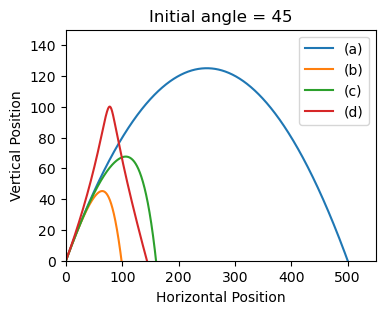

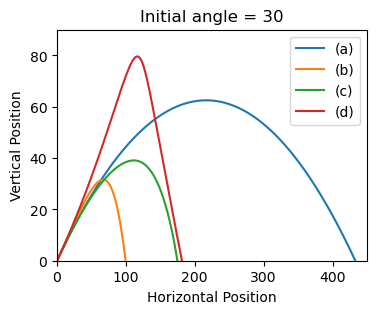

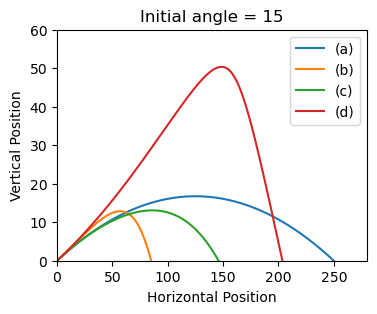

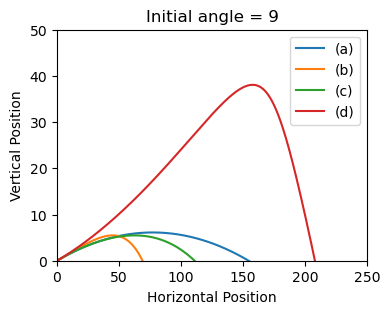

In [39]:
lims=np.array([[550,150],[450,90],[280,60],[250,50]])
for k in range(angles):
    plt.figure(figsize=(4, 3))
    plt.plot([Data[k,0,j,0] for j in range(N)], [Data[k,0,j,2] for j in range(N)], label='(a)')
    plt.plot([Data[k,1,j,0] for j in range(N)], [Data[k,1,j,2] for j in range(N)], label='(b)')
    plt.plot([Data[k,2,j,0] for j in range(N)], [Data[k,2,j,2] for j in range(N)], label='(c)')
    plt.plot([Data[k,3,j,0] for j in range(N)], [Data[k,3,j,2] for j in range(N)], label='(d)')
    plt.legend()
    plt.title('Initial angle = %.0f'%(theta[k]*180/np.pi))
    plt.xlabel('Horizontal Position')
    plt.ylabel('Vertical Position')
    plt.xlim(0,lims[k,0])
    plt.ylim(0,lims[k,1])
    plt.show()